In [1]:
import sys
!{sys.executable} -m pip install --quiet opencv-python azure-cognitiveservices-vision-face

import os, requests, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
key = '6bc7f05e83d542e89310f3e35c30c872' # ключ выглядит примерно так: 'e408f9b7c8e349ee8f335567432df30'
endpoint = 'https://itfest-task3.cognitiveservices.azure.com/' # убедитесь, что конечная точка правильная

In [3]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))
face_url = 'https://st3.depositphotos.com/9881890/13396/i/600/depositphotos_133960224-stock-photo-smiling-young-man.jpg'
res = cli.face.detect_with_url(face_url,return_face_landmarks=True)
print(res[0].face_landmarks.as_dict())

{'pupil_left': {'x': 268.3, 'y': 173.7}, 'pupil_right': {'x': 322.8, 'y': 172.6}, 'nose_tip': {'x': 297.6, 'y': 210.9}, 'mouth_left': {'x': 273.6, 'y': 229.4}, 'mouth_right': {'x': 328.9, 'y': 228.6}, 'eyebrow_left_outer': {'x': 243.9, 'y': 170.2}, 'eyebrow_left_inner': {'x': 279.4, 'y': 166.3}, 'eye_left_outer': {'x': 259.8, 'y': 175.1}, 'eye_left_top': {'x': 268.6, 'y': 170.8}, 'eye_left_bottom': {'x': 269.3, 'y': 177.4}, 'eye_left_inner': {'x': 277.0, 'y': 174.6}, 'eyebrow_right_inner': {'x': 306.7, 'y': 166.0}, 'eyebrow_right_outer': {'x': 345.8, 'y': 167.3}, 'eye_right_inner': {'x': 314.0, 'y': 173.9}, 'eye_right_top': {'x': 322.8, 'y': 168.9}, 'eye_right_bottom': {'x': 323.3, 'y': 176.0}, 'eye_right_outer': {'x': 331.1, 'y': 173.5}, 'nose_root_left': {'x': 287.6, 'y': 177.7}, 'nose_root_right': {'x': 303.4, 'y': 177.3}, 'nose_left_alar_top': {'x': 283.5, 'y': 198.3}, 'nose_right_alar_top': {'x': 308.6, 'y': 197.3}, 'nose_left_alar_out_tip': {'x': 278.5, 'y': 208.6}, 'nose_right_a

Анализируем изображение:  images\1-1.jpg


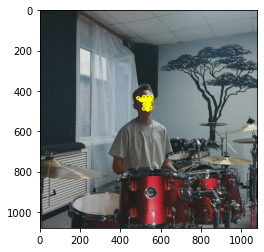

In [4]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fn = glob.glob('images/*')[0]
print('Анализируем изображение: ',fn)

img = imread(fn)
cli.face.detect_with_url(face_url)
with open(fn,'rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,255,0),5)
plt.imshow(img)

In [5]:
filenames = []
images = []
imagepoints = []
cli.face.detect_with_url(face_url)
for fn in glob.glob("images/*")[0:10]:
    print("Идёт обработка {} ".format(fn),end='')
    try:
        with open(fn,'rb') as f:
            res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    except:
        print(' - ОШИБКА - ',end='')
        res = []
    print(' найдено {} лиц'.format(len(res)))
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Идёт обработка images\1-1.jpg  найдено 1 лиц
Идёт обработка images\1-10.jpg  найдено 1 лиц
Идёт обработка images\1-11.jpg  найдено 1 лиц
Идёт обработка images\1-12.jpg  найдено 1 лиц
Идёт обработка images\1-13.jpg  найдено 1 лиц
Идёт обработка images\1-2.jpg  найдено 1 лиц
Идёт обработка images\1-3.jpg  найдено 1 лиц
Идёт обработка images\1-4.jpg  найдено 1 лиц
Идёт обработка images\1-5.jpg  найдено 1 лиц
Идёт обработка images\1-6.jpg  найдено 1 лиц


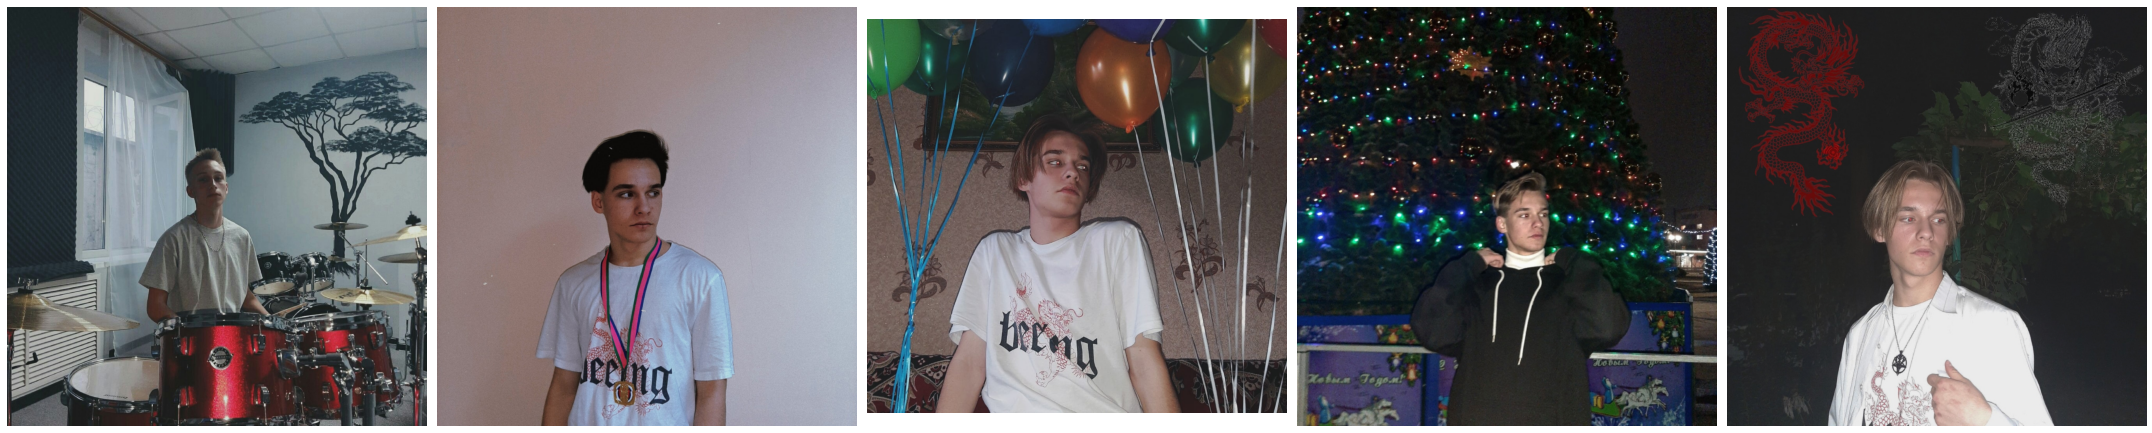

In [6]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

In [7]:
target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

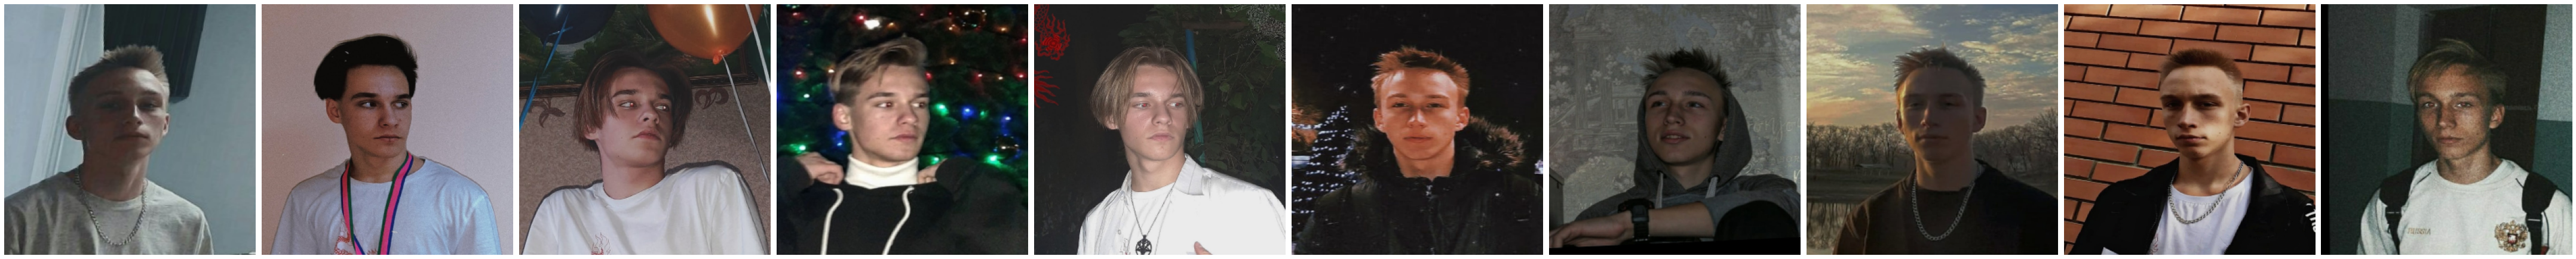

In [8]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:13])

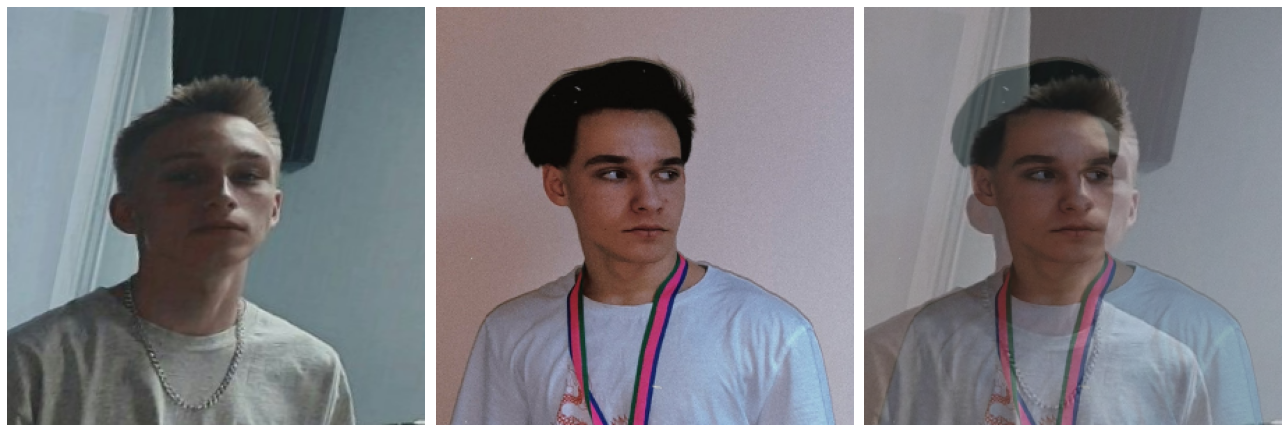

In [9]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)/255.0
    return res

display_images([img_aligned[0],img_aligned[1],merge(img_aligned[0:2])])


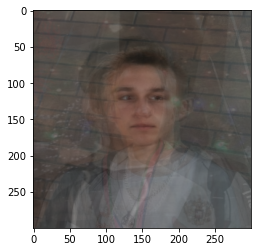

In [10]:
res = merge(img_aligned)
plt.imshow(res)


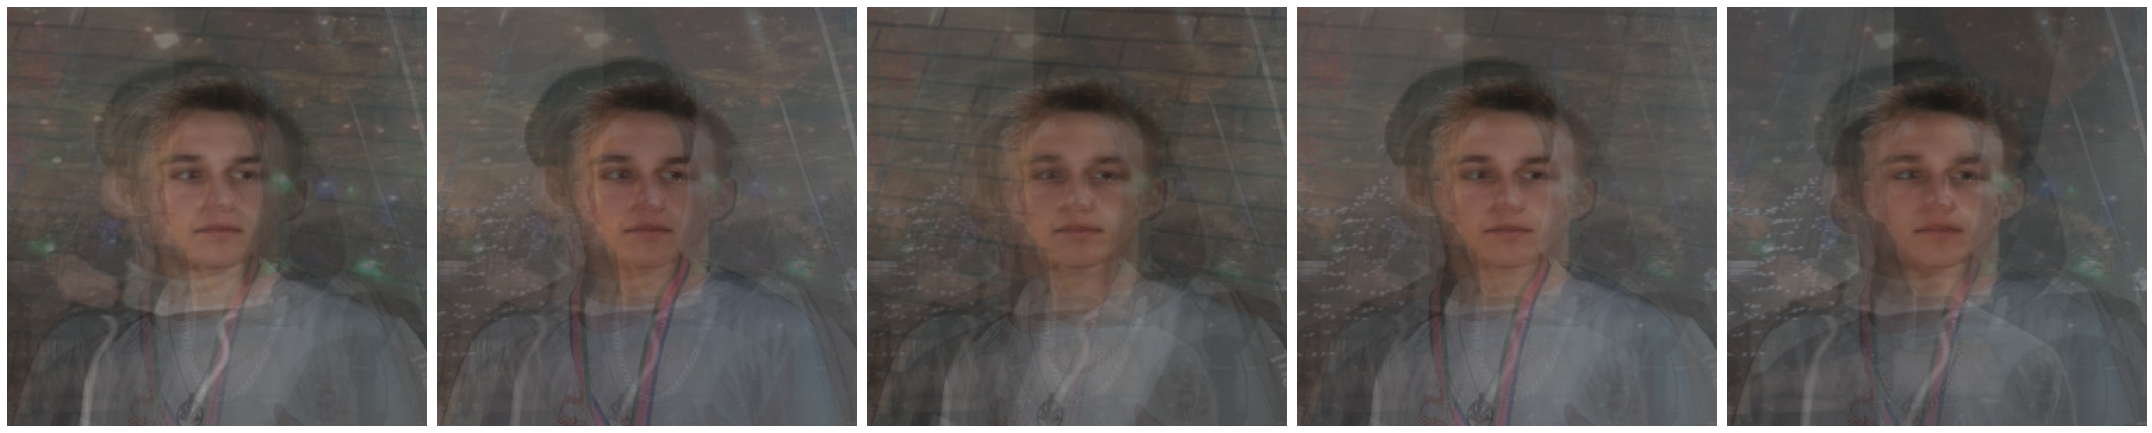

In [11]:
imgs = [merge(img_aligned,np.random.random(len(img_aligned))) for _ in range(5)]
display_images(imgs)

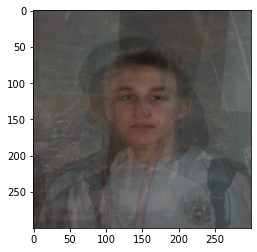

In [12]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

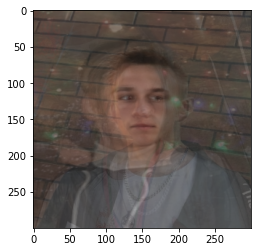

In [13]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

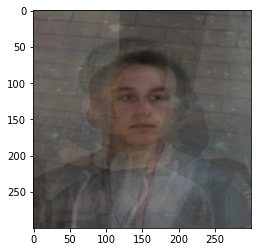

In [14]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

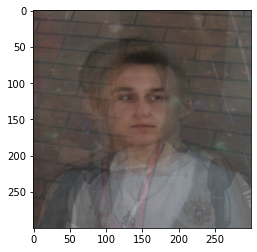

In [15]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

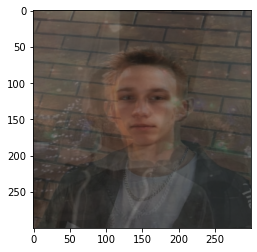

In [16]:
res = merge(img_aligned,np.random.random(len(img_aligned)))
plt.imshow(res)

In [17]:
img = (cv2.cvtColor(res,cv2.COLOR_BGR2RGB)*255.0).astype(np.int)
cv2.imwrite('result.jpg',img)

True

In [18]:
import requests
requests.post('https://contestman.azurewebsites.net/api/artsubmit?name=itfest',data=cv2.imencode('.jpg',img)[1].tobytes())

<Response [200]>